In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
import pack_ga
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
stop final relax at some point
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties fo

In [2]:
%load_ext pyinstrument

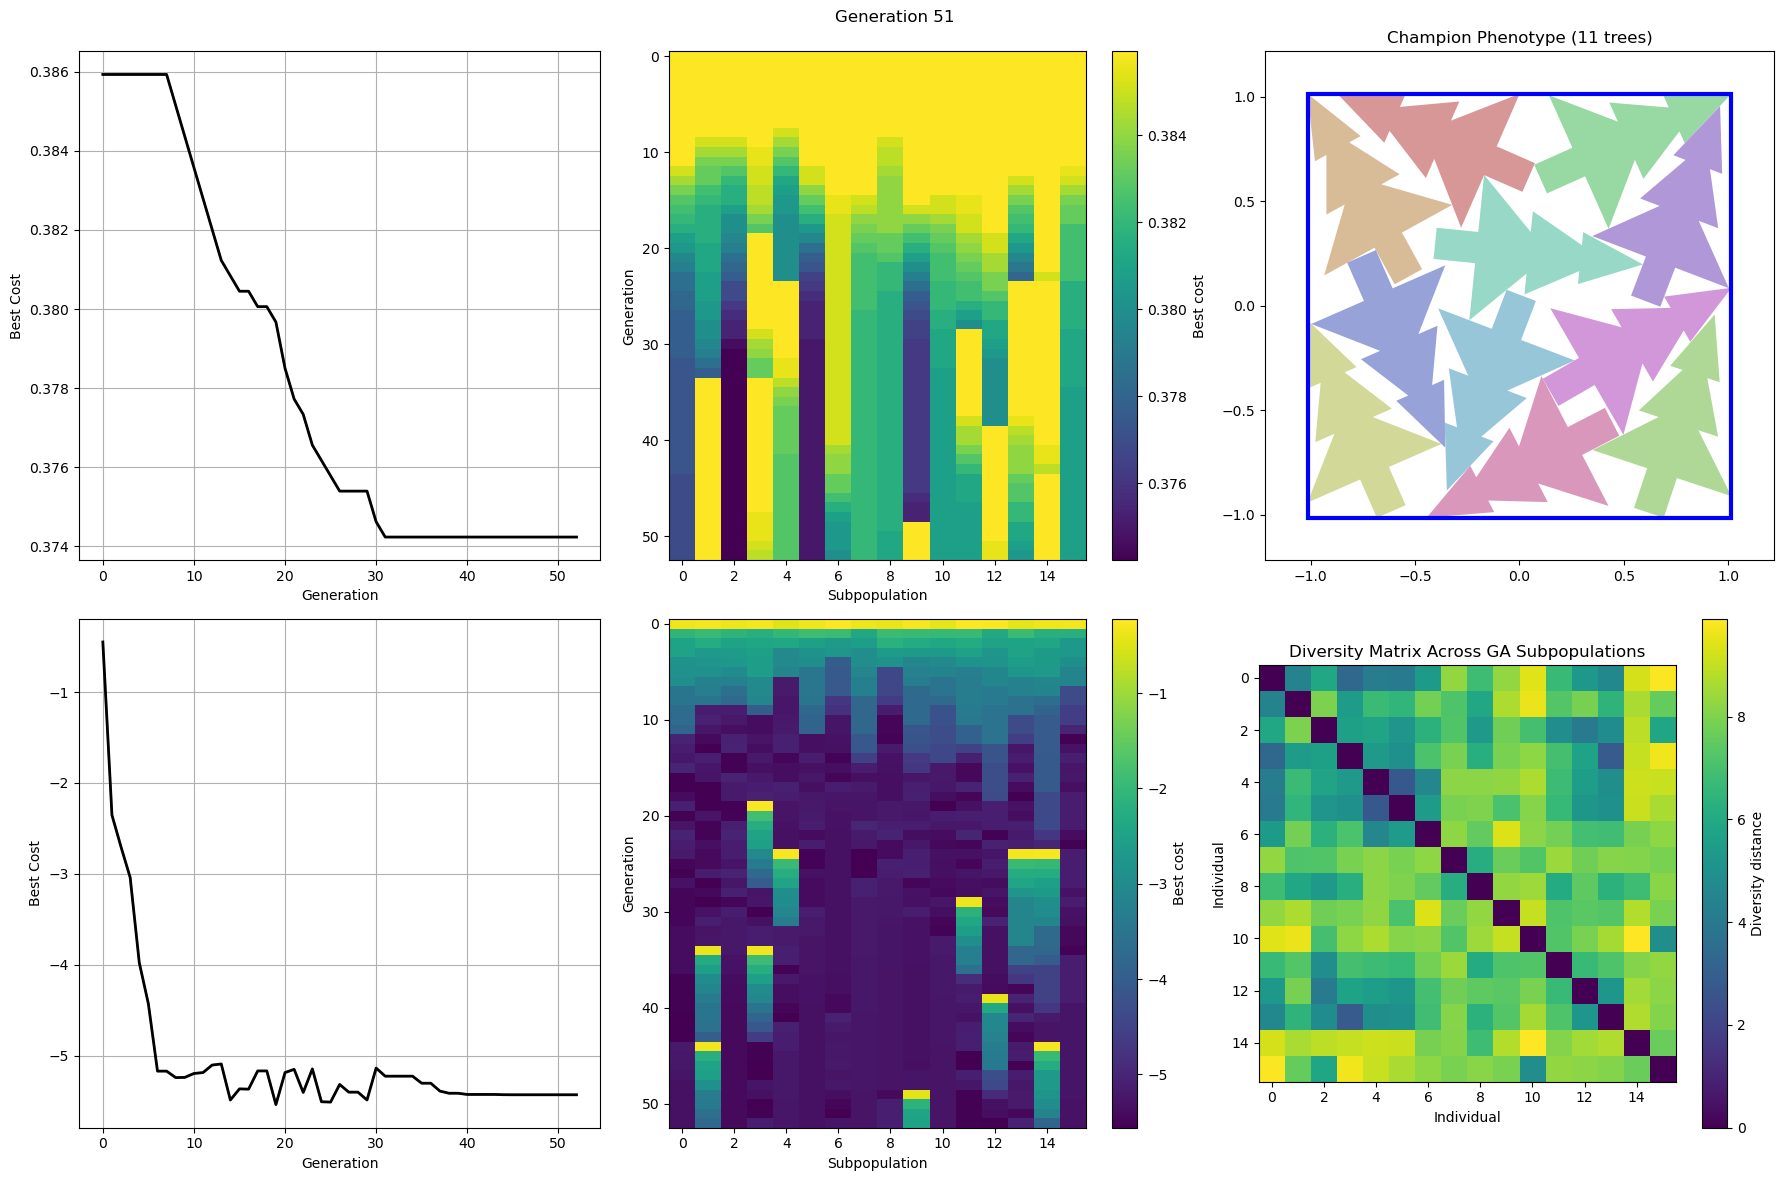

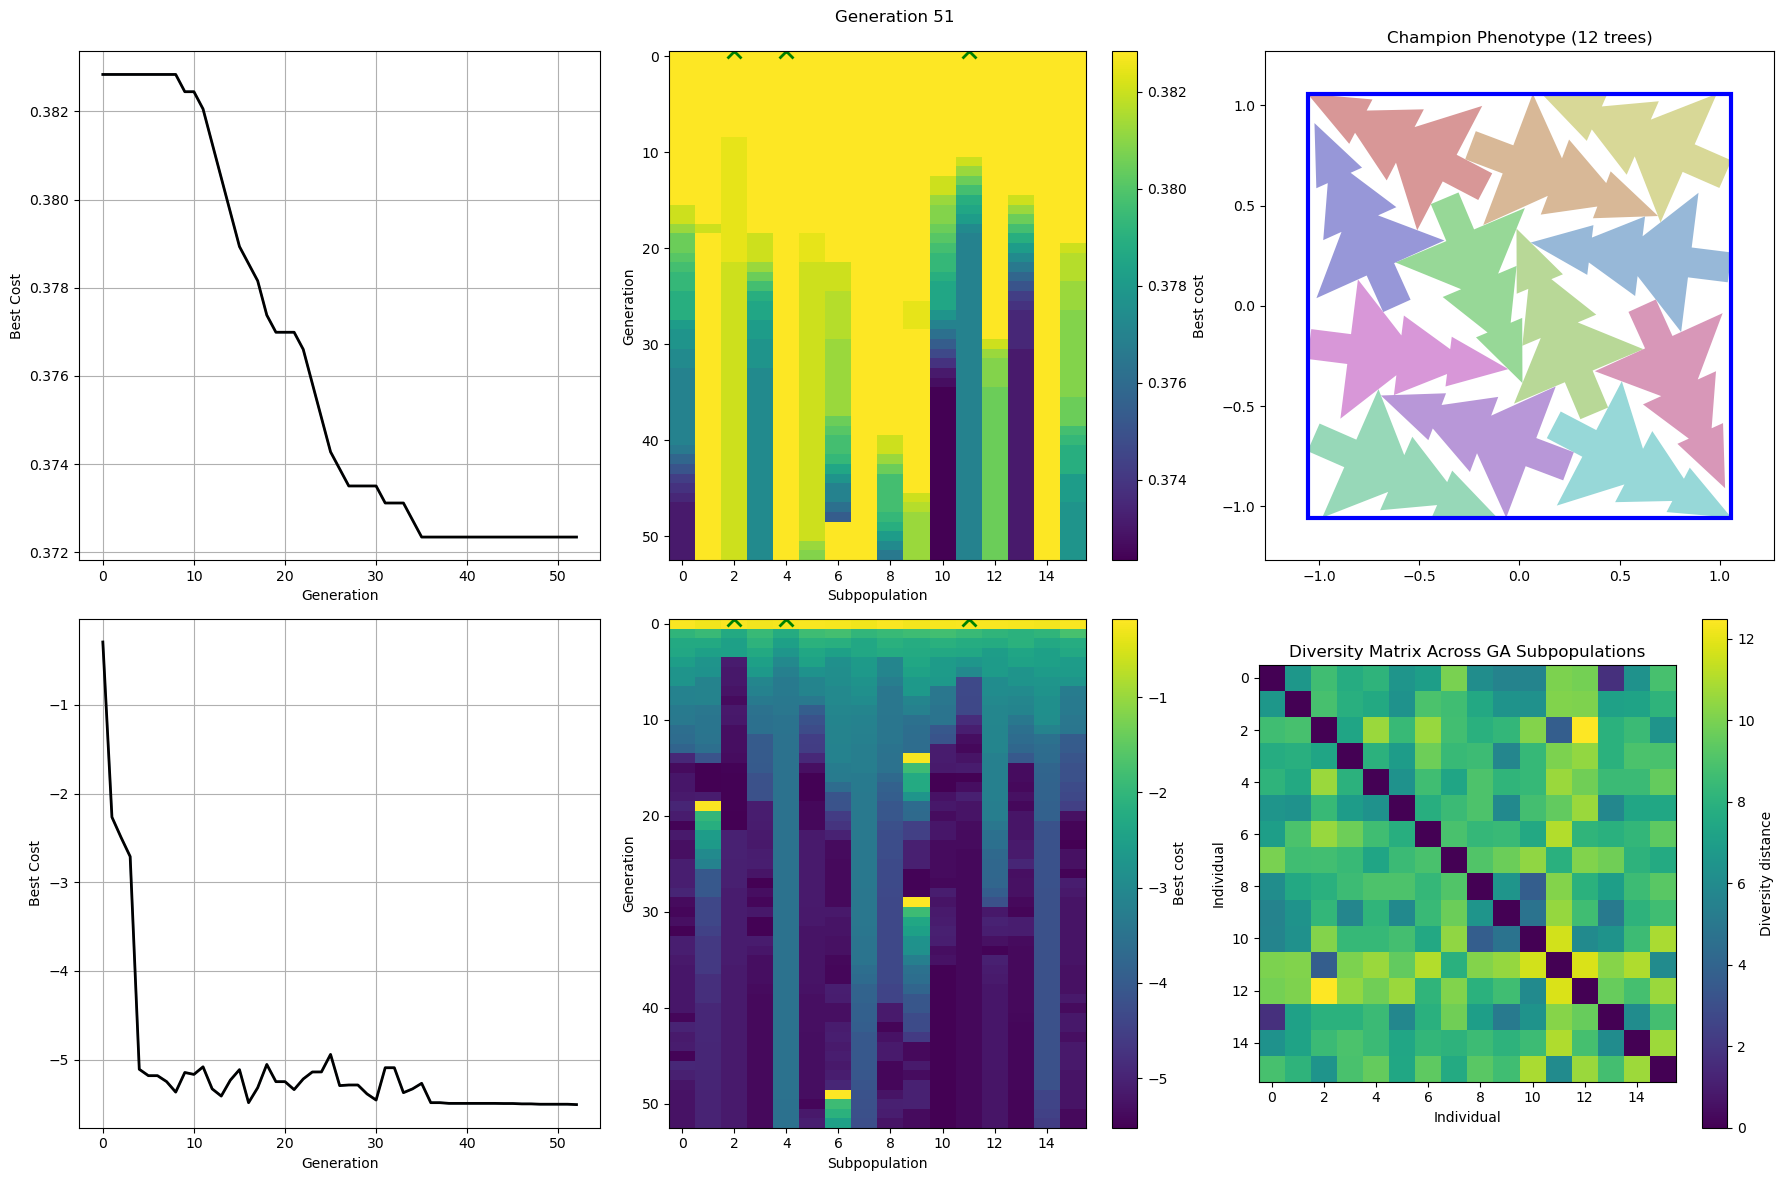

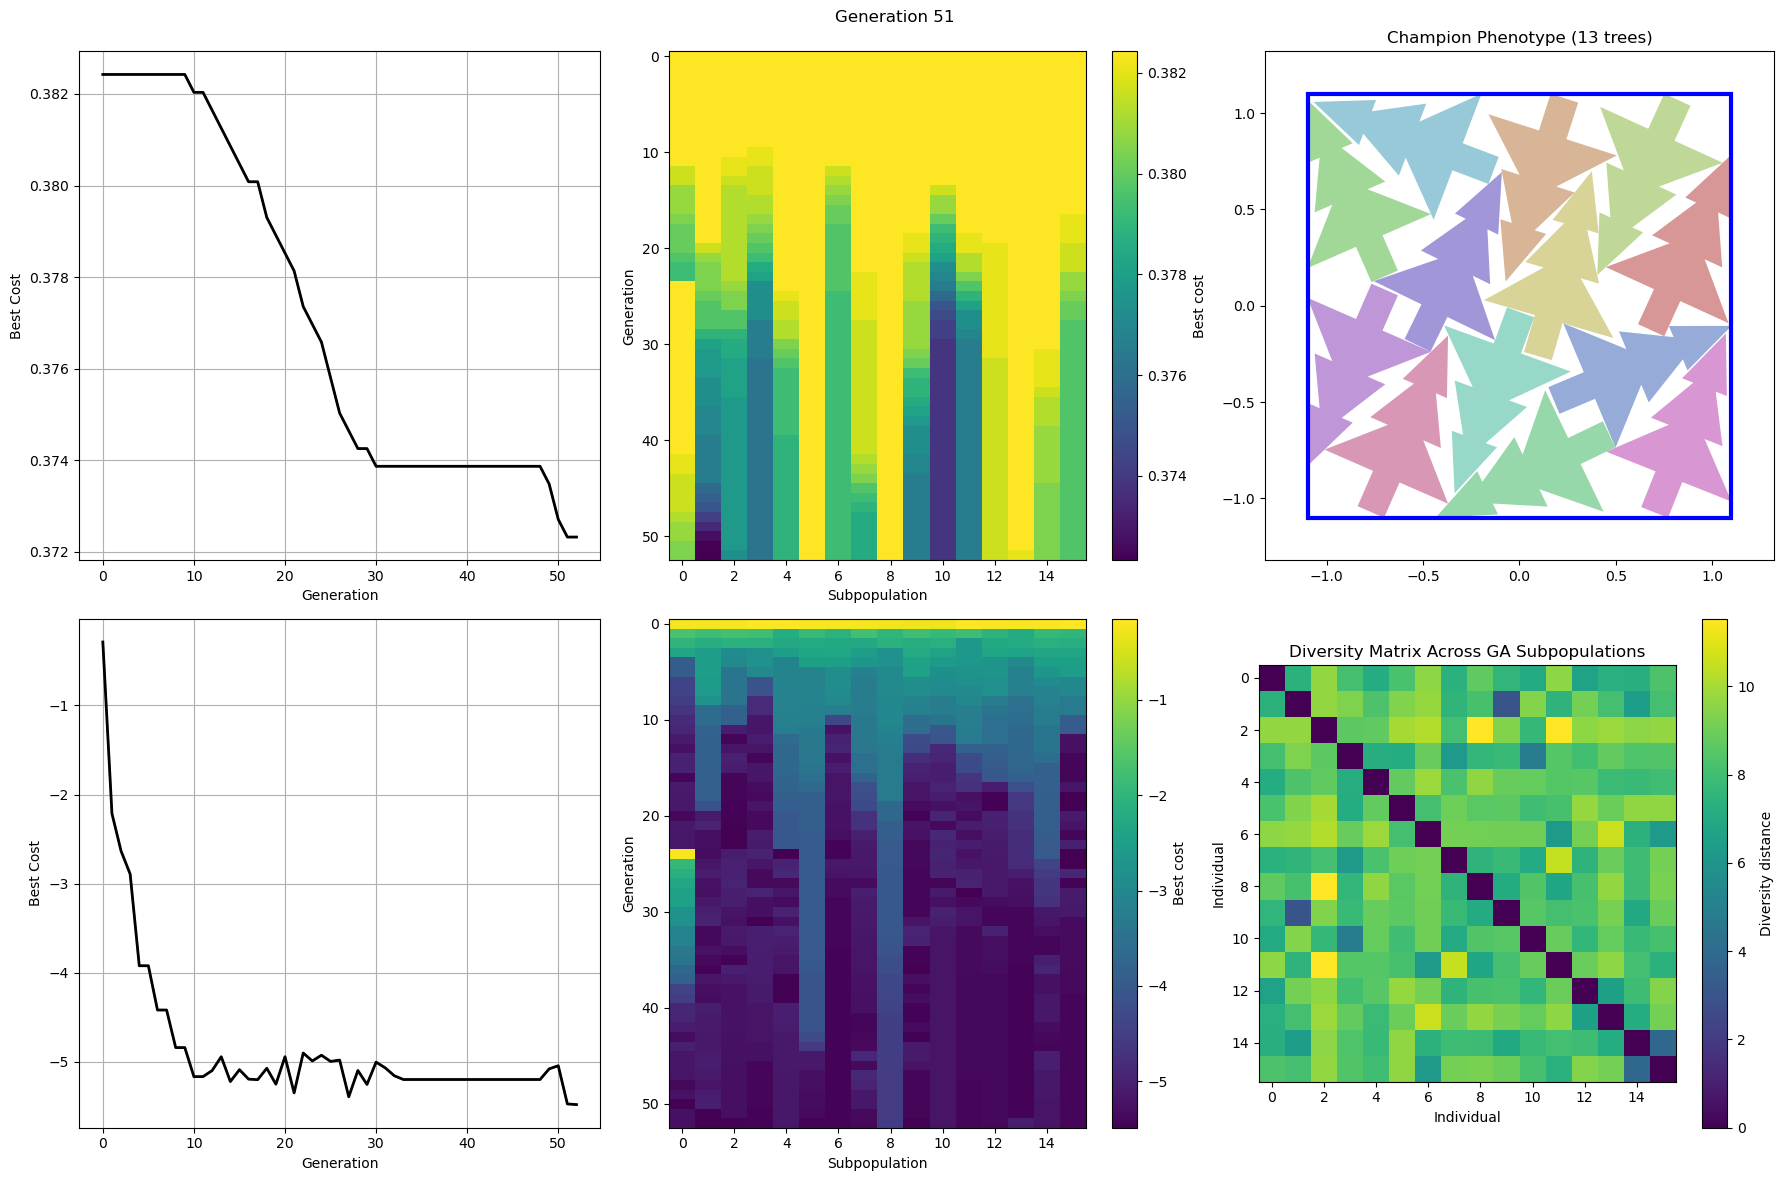

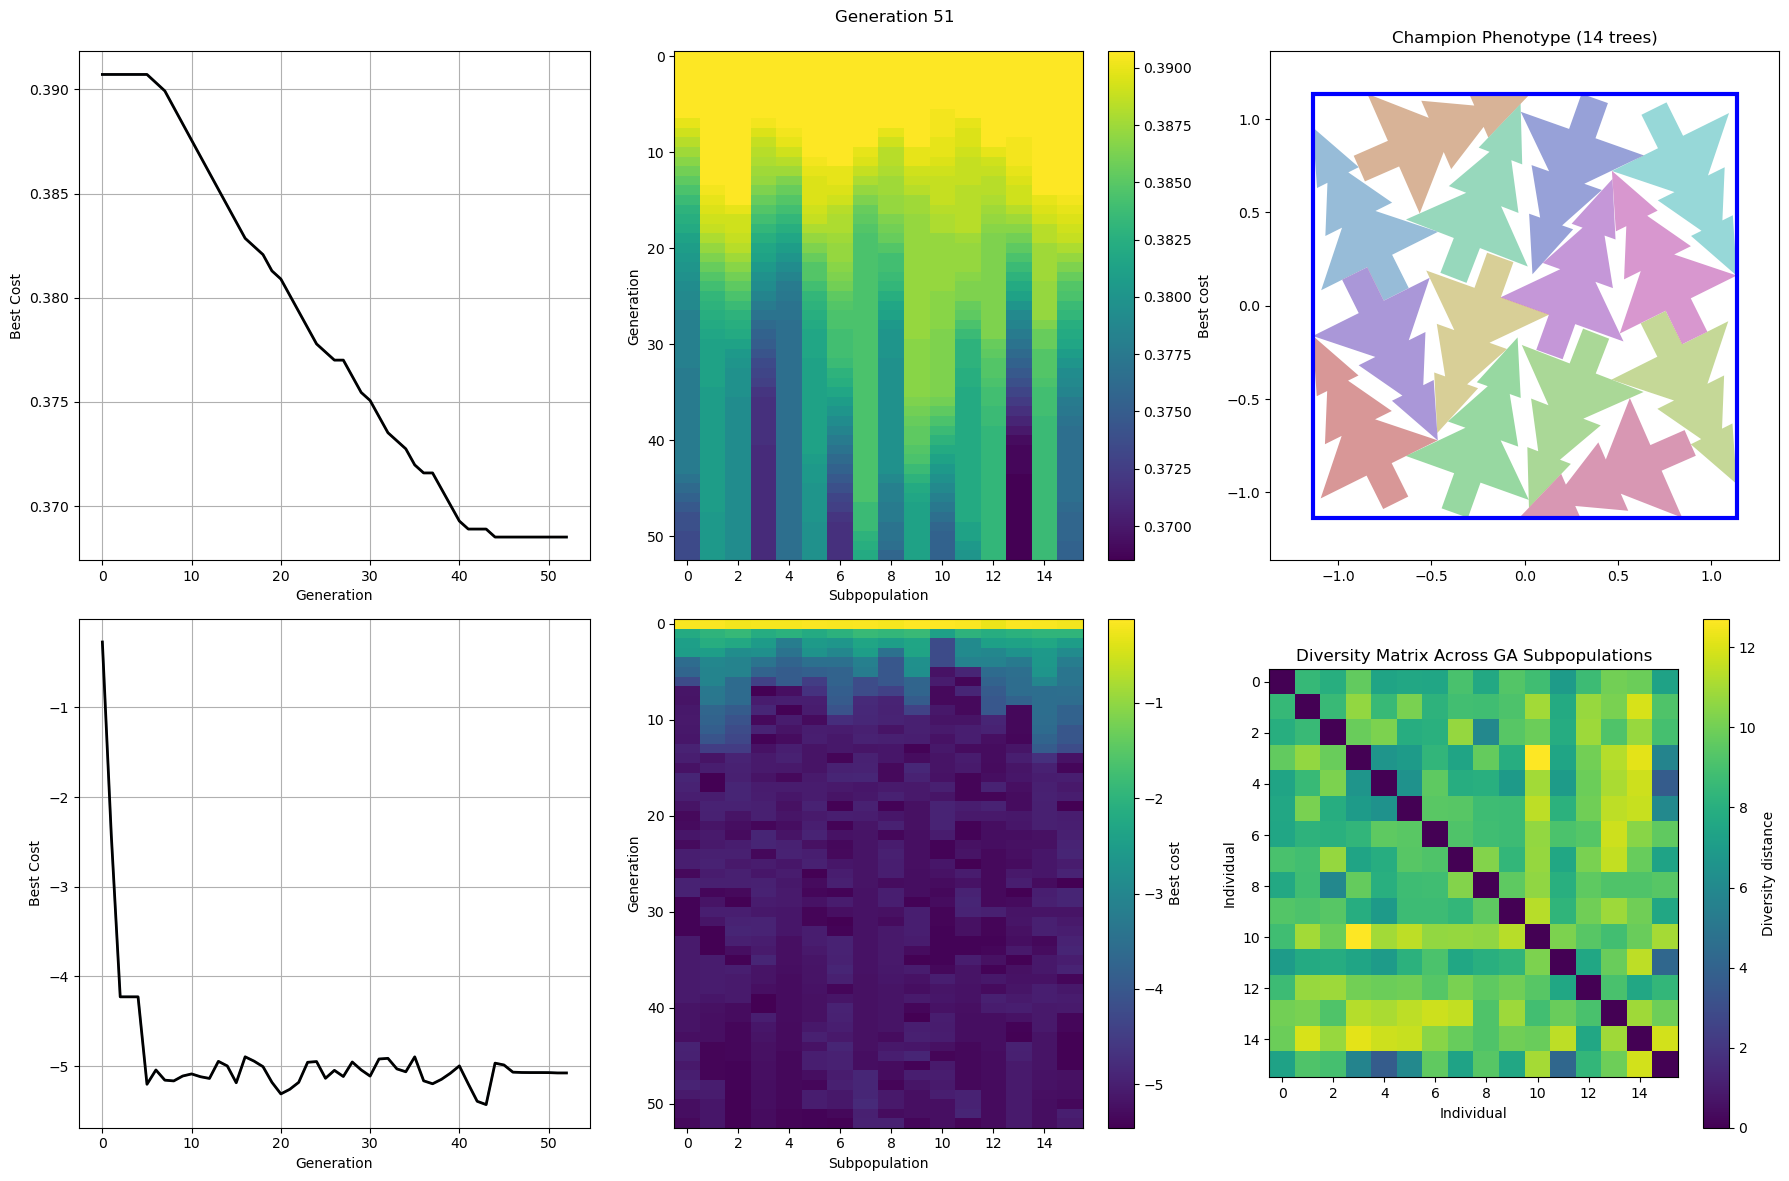

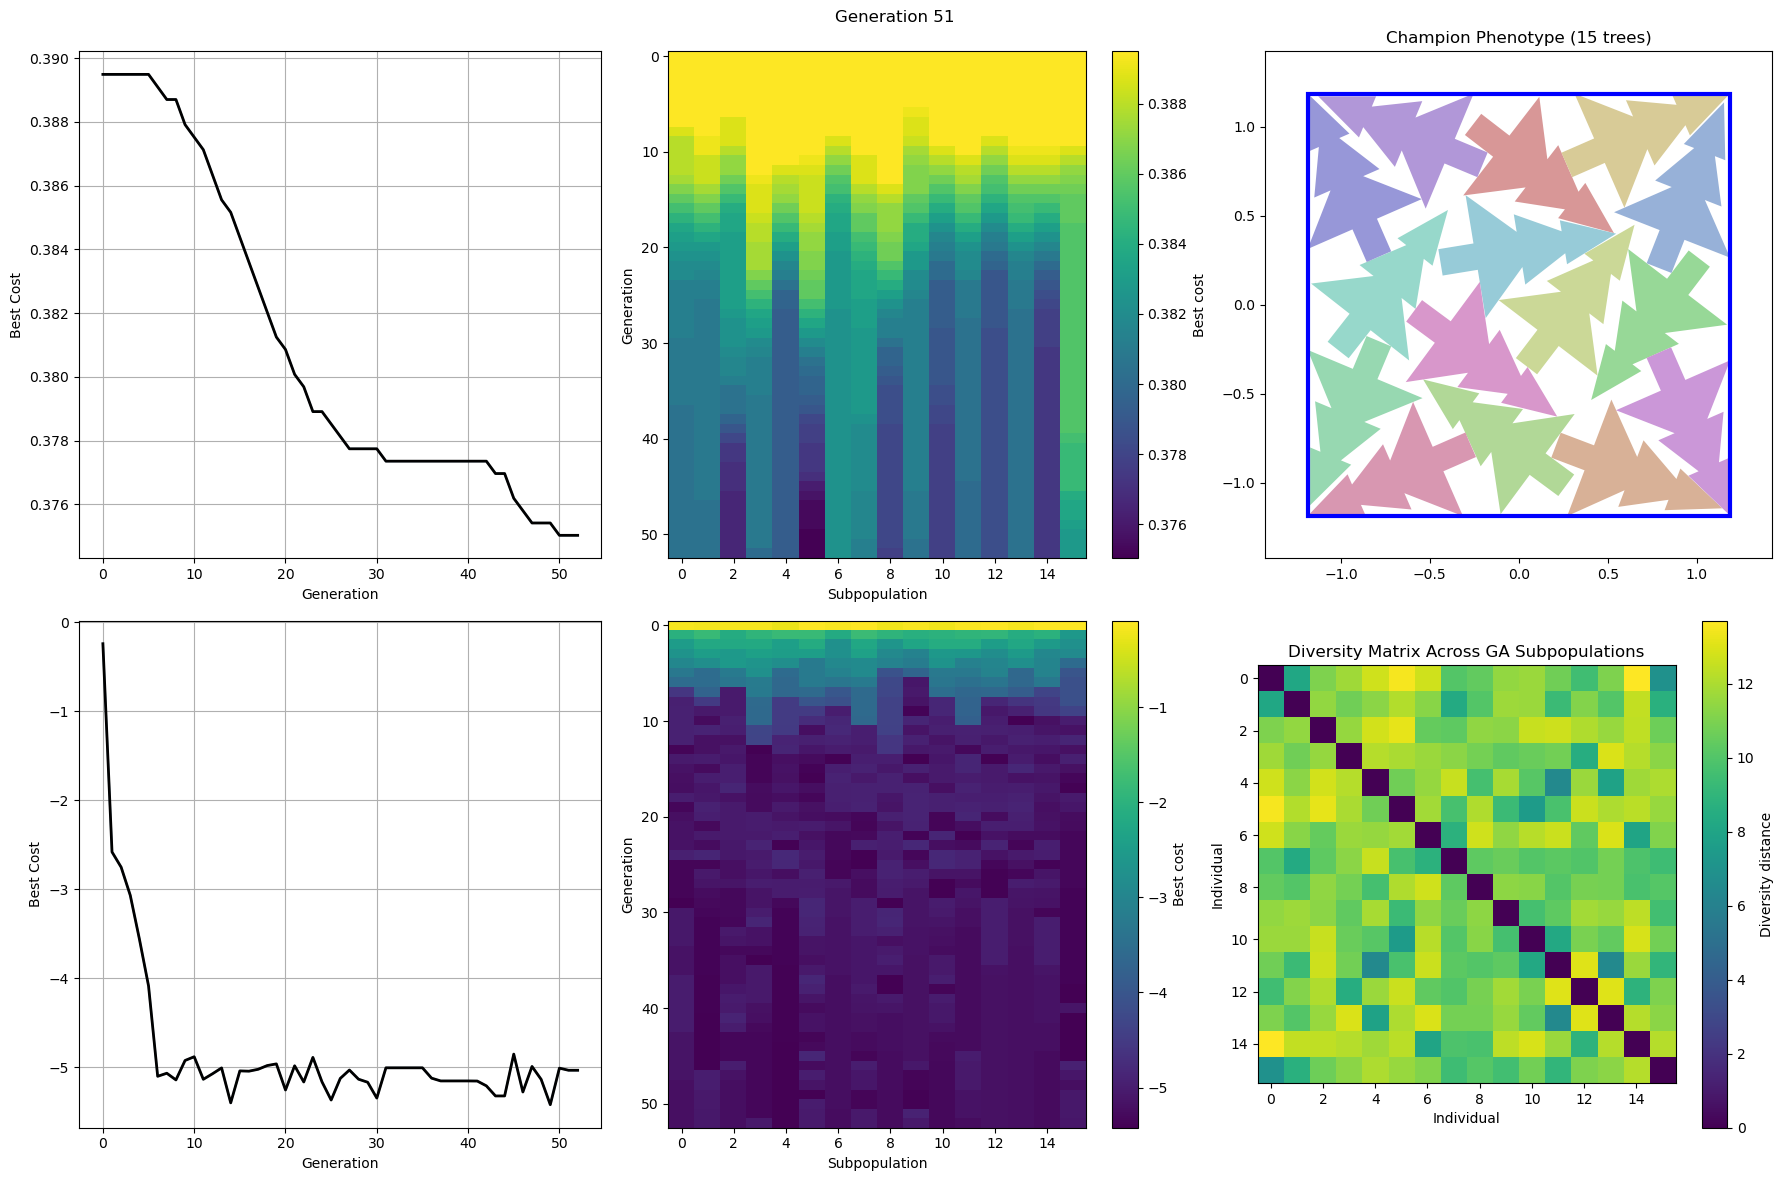

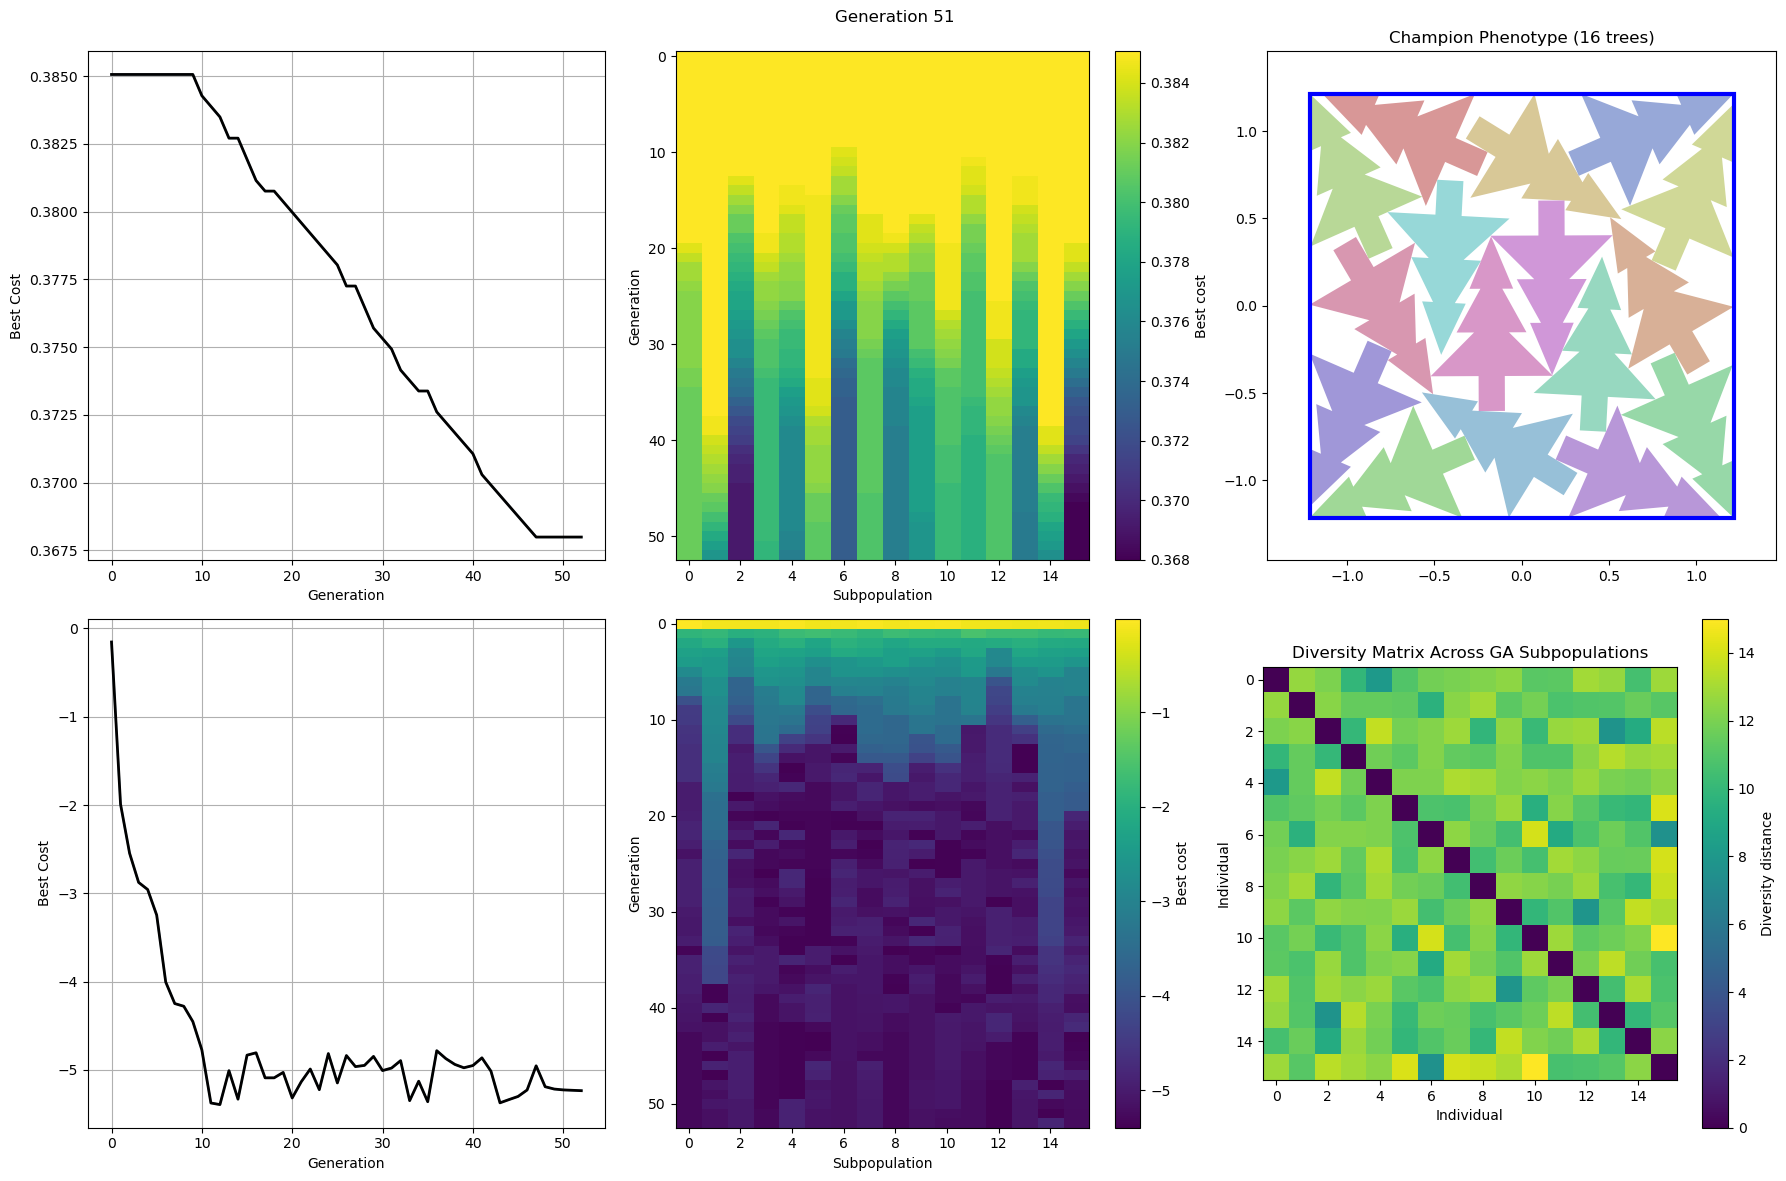

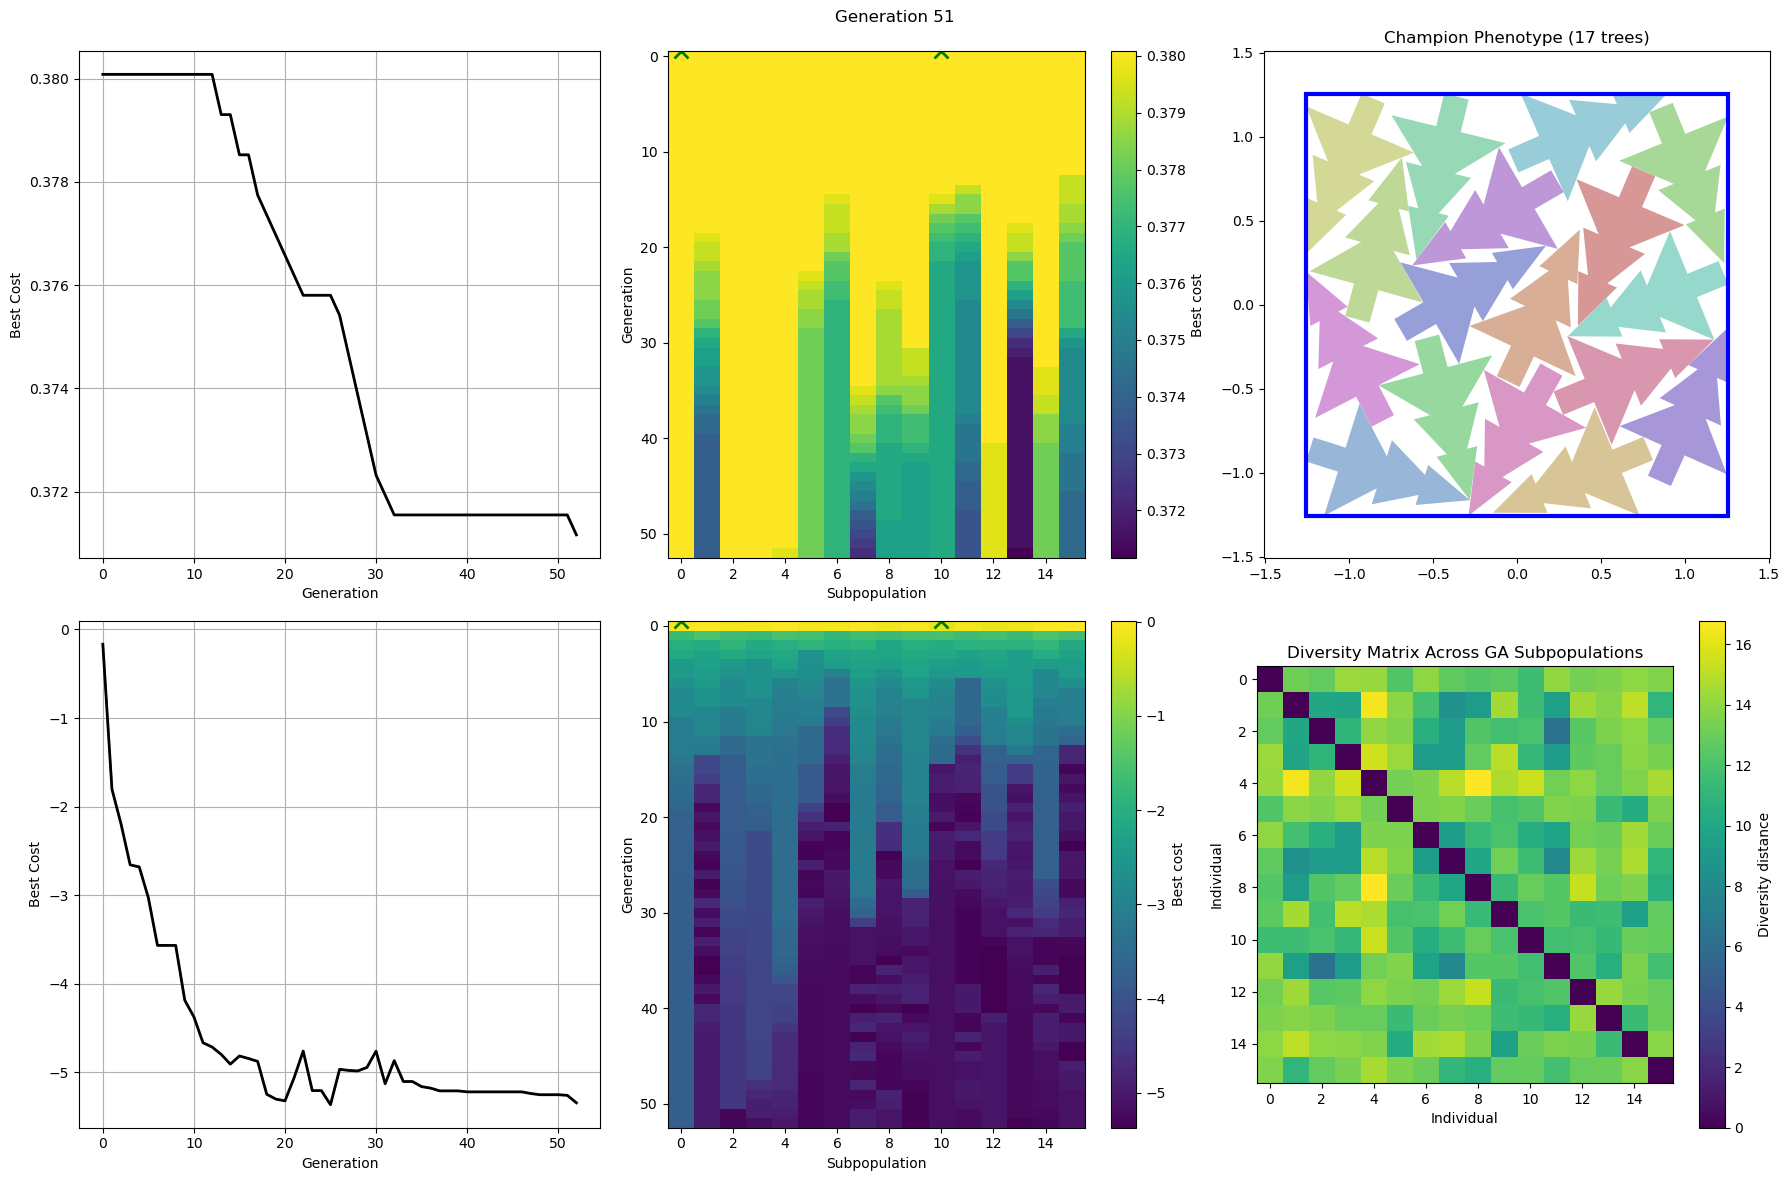

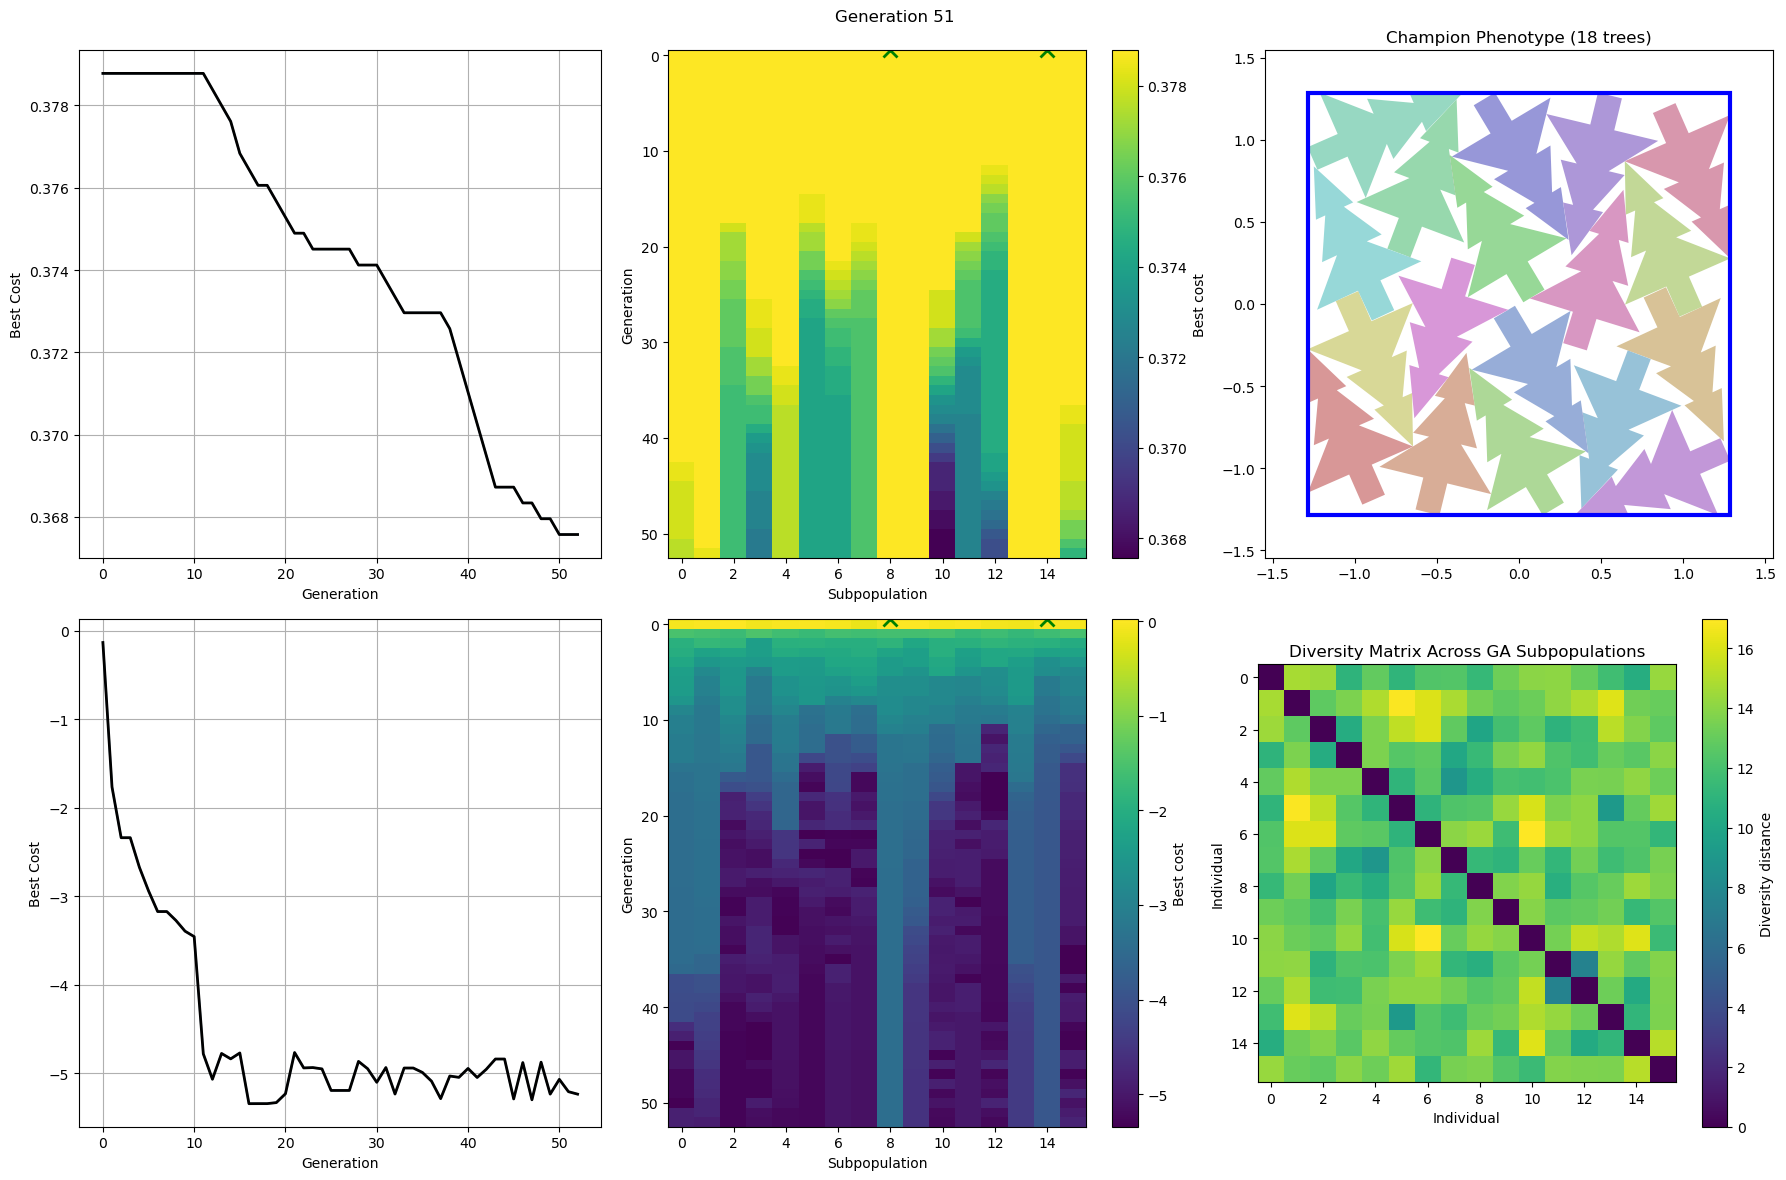

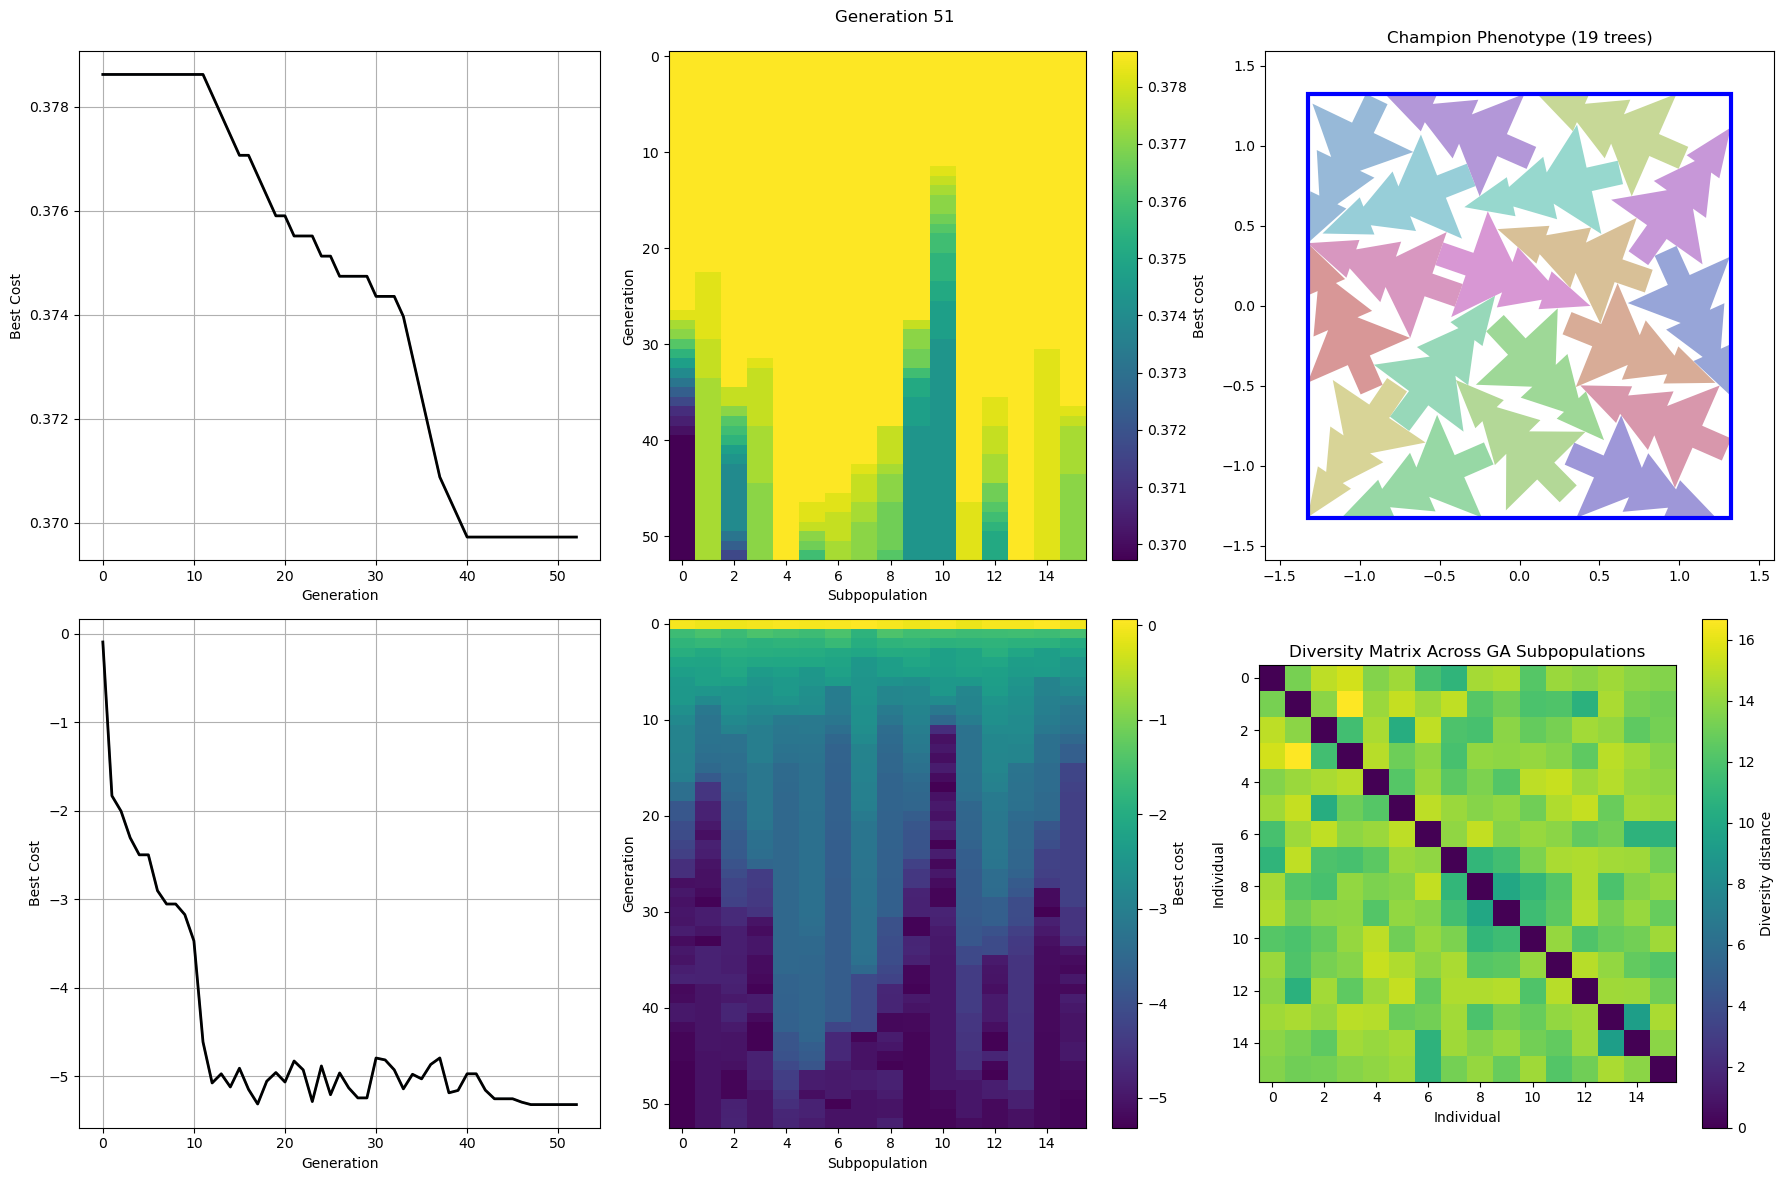

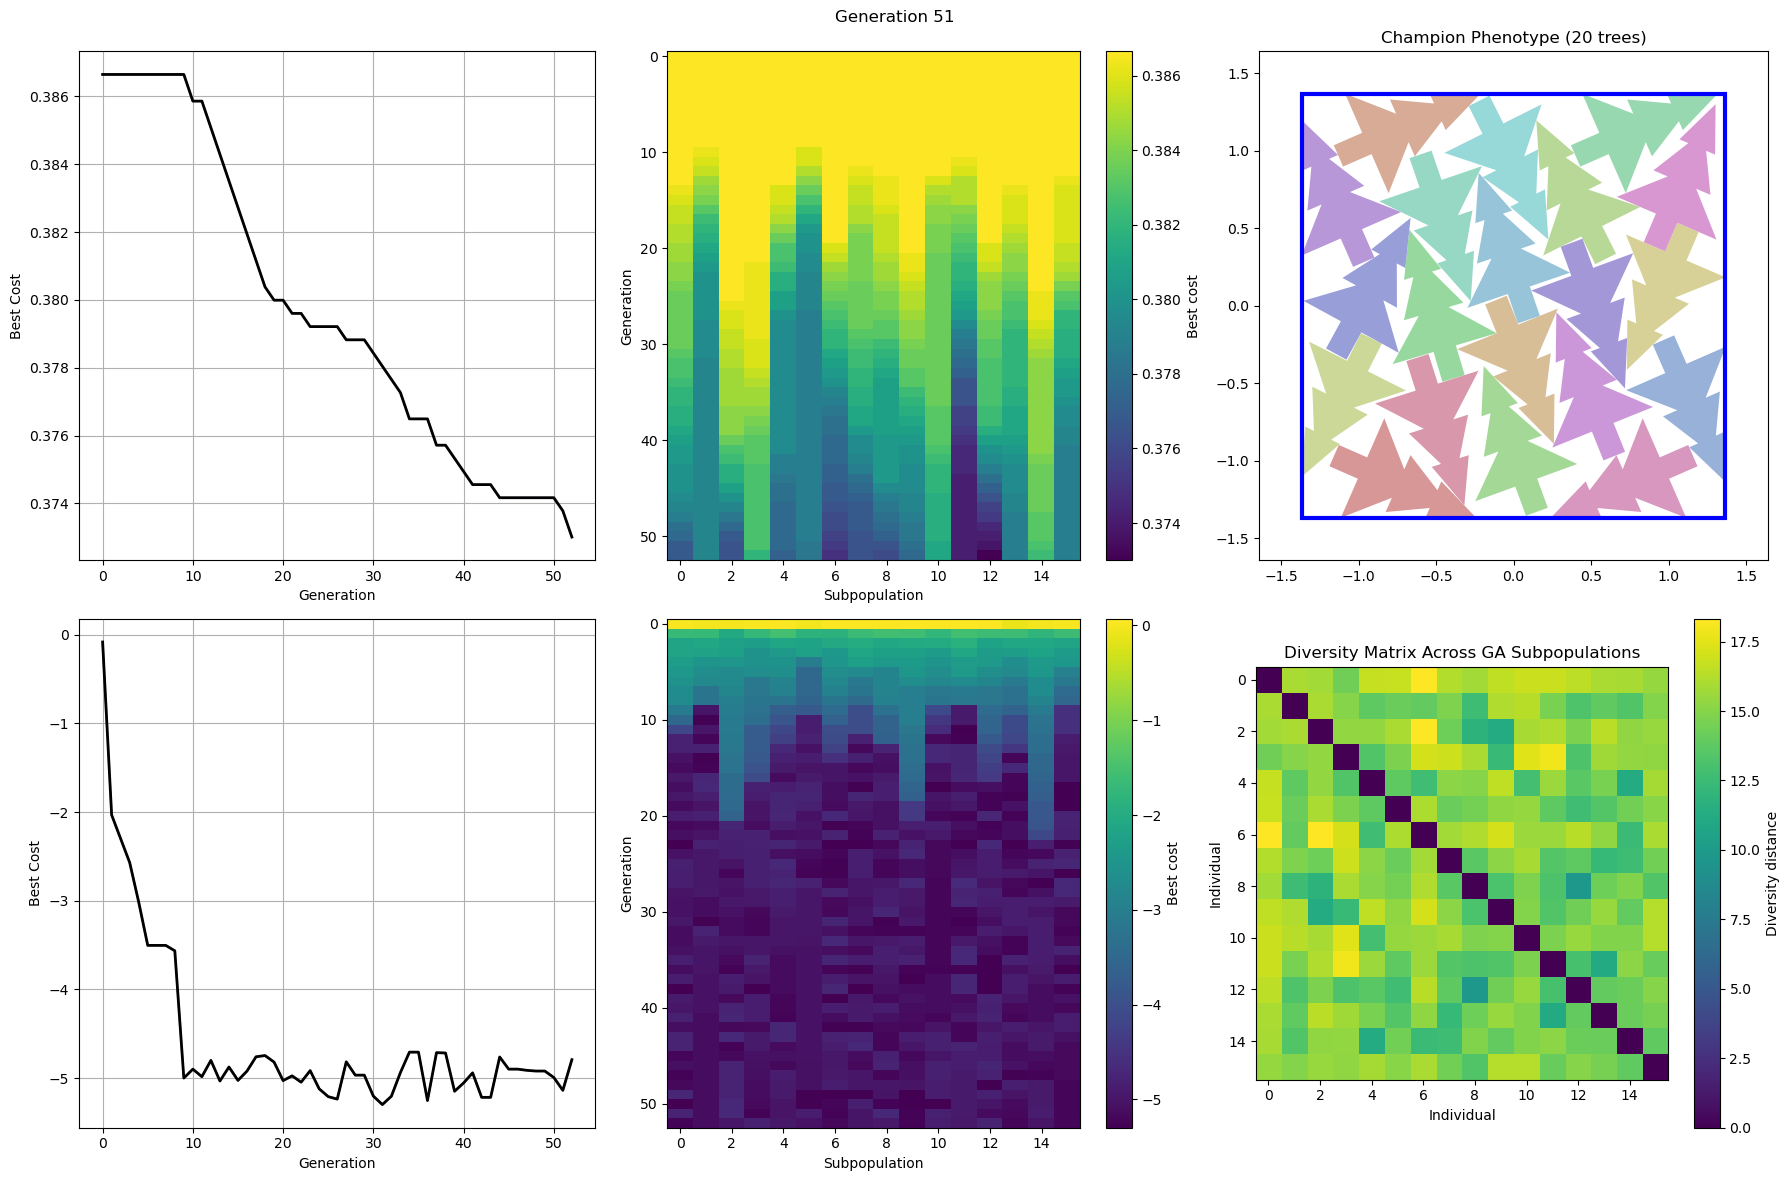

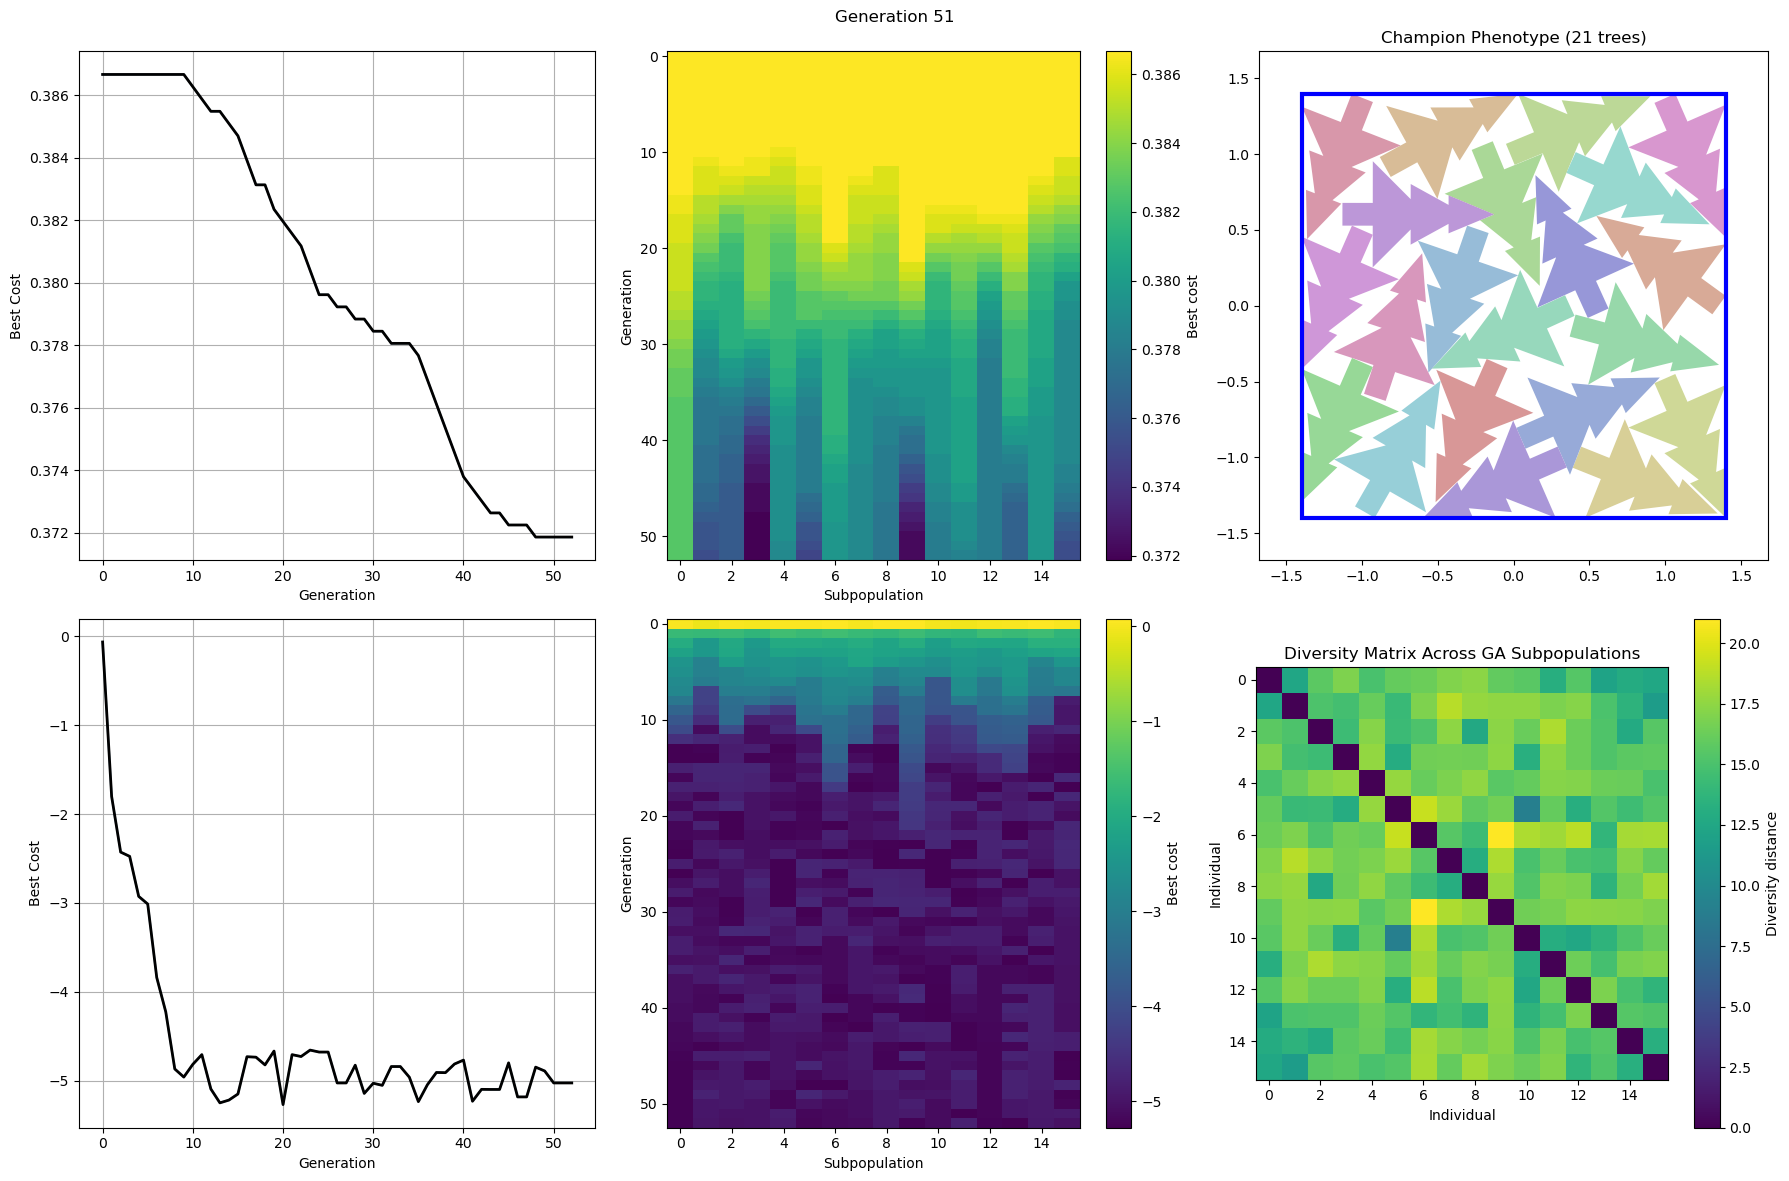

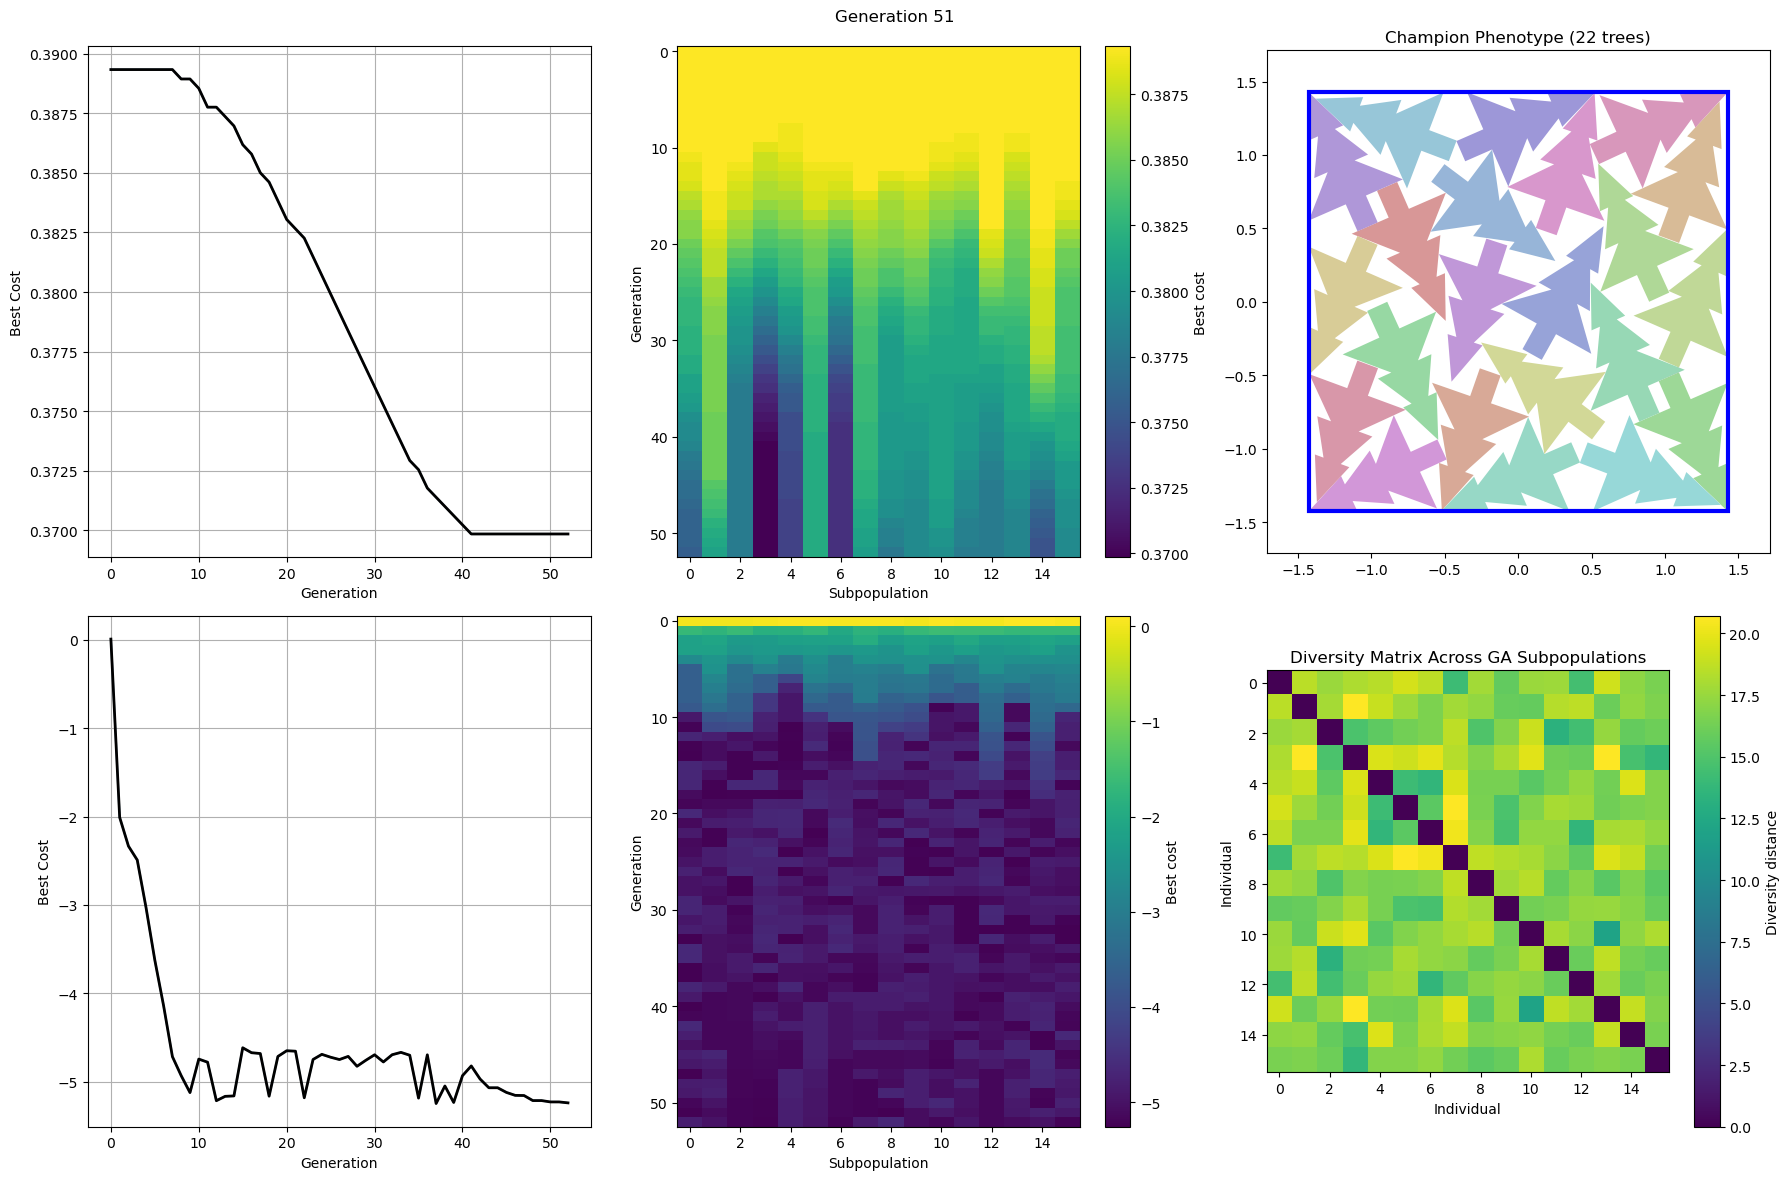

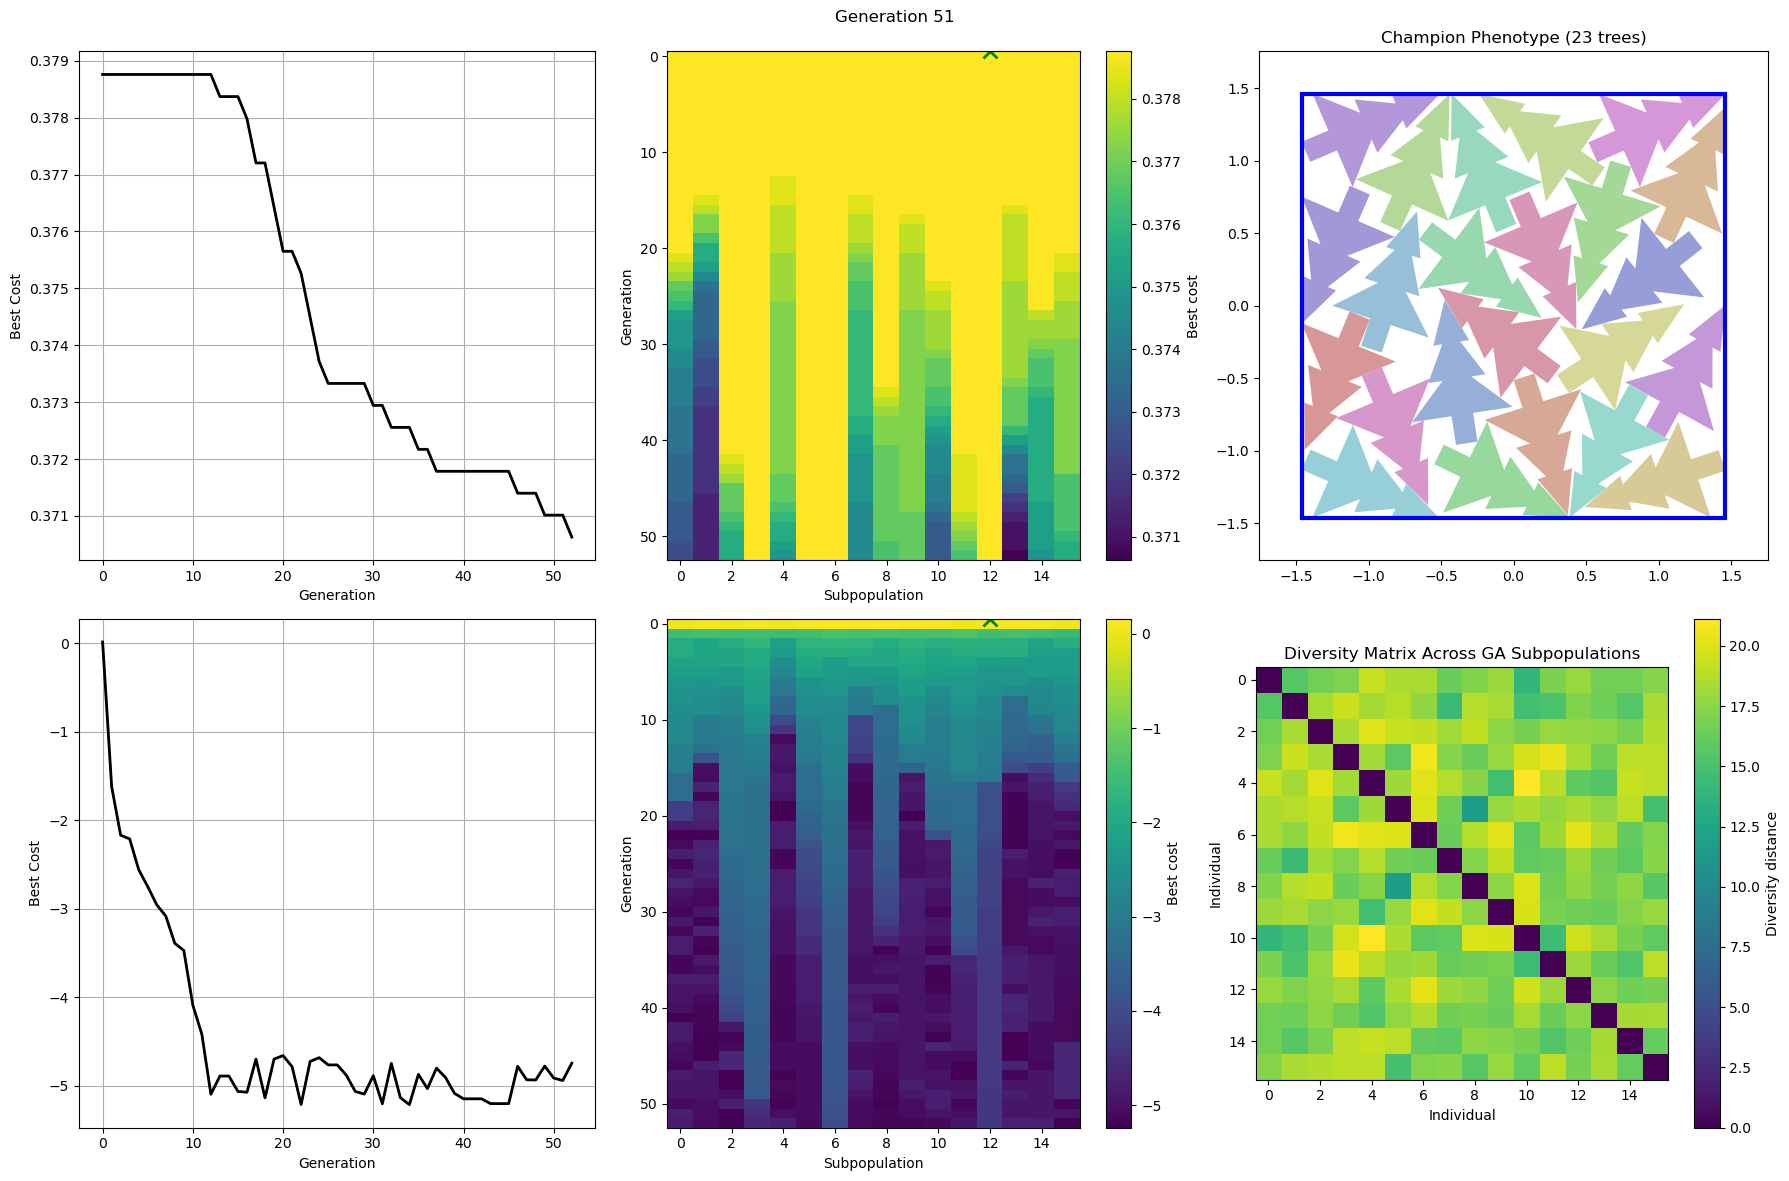

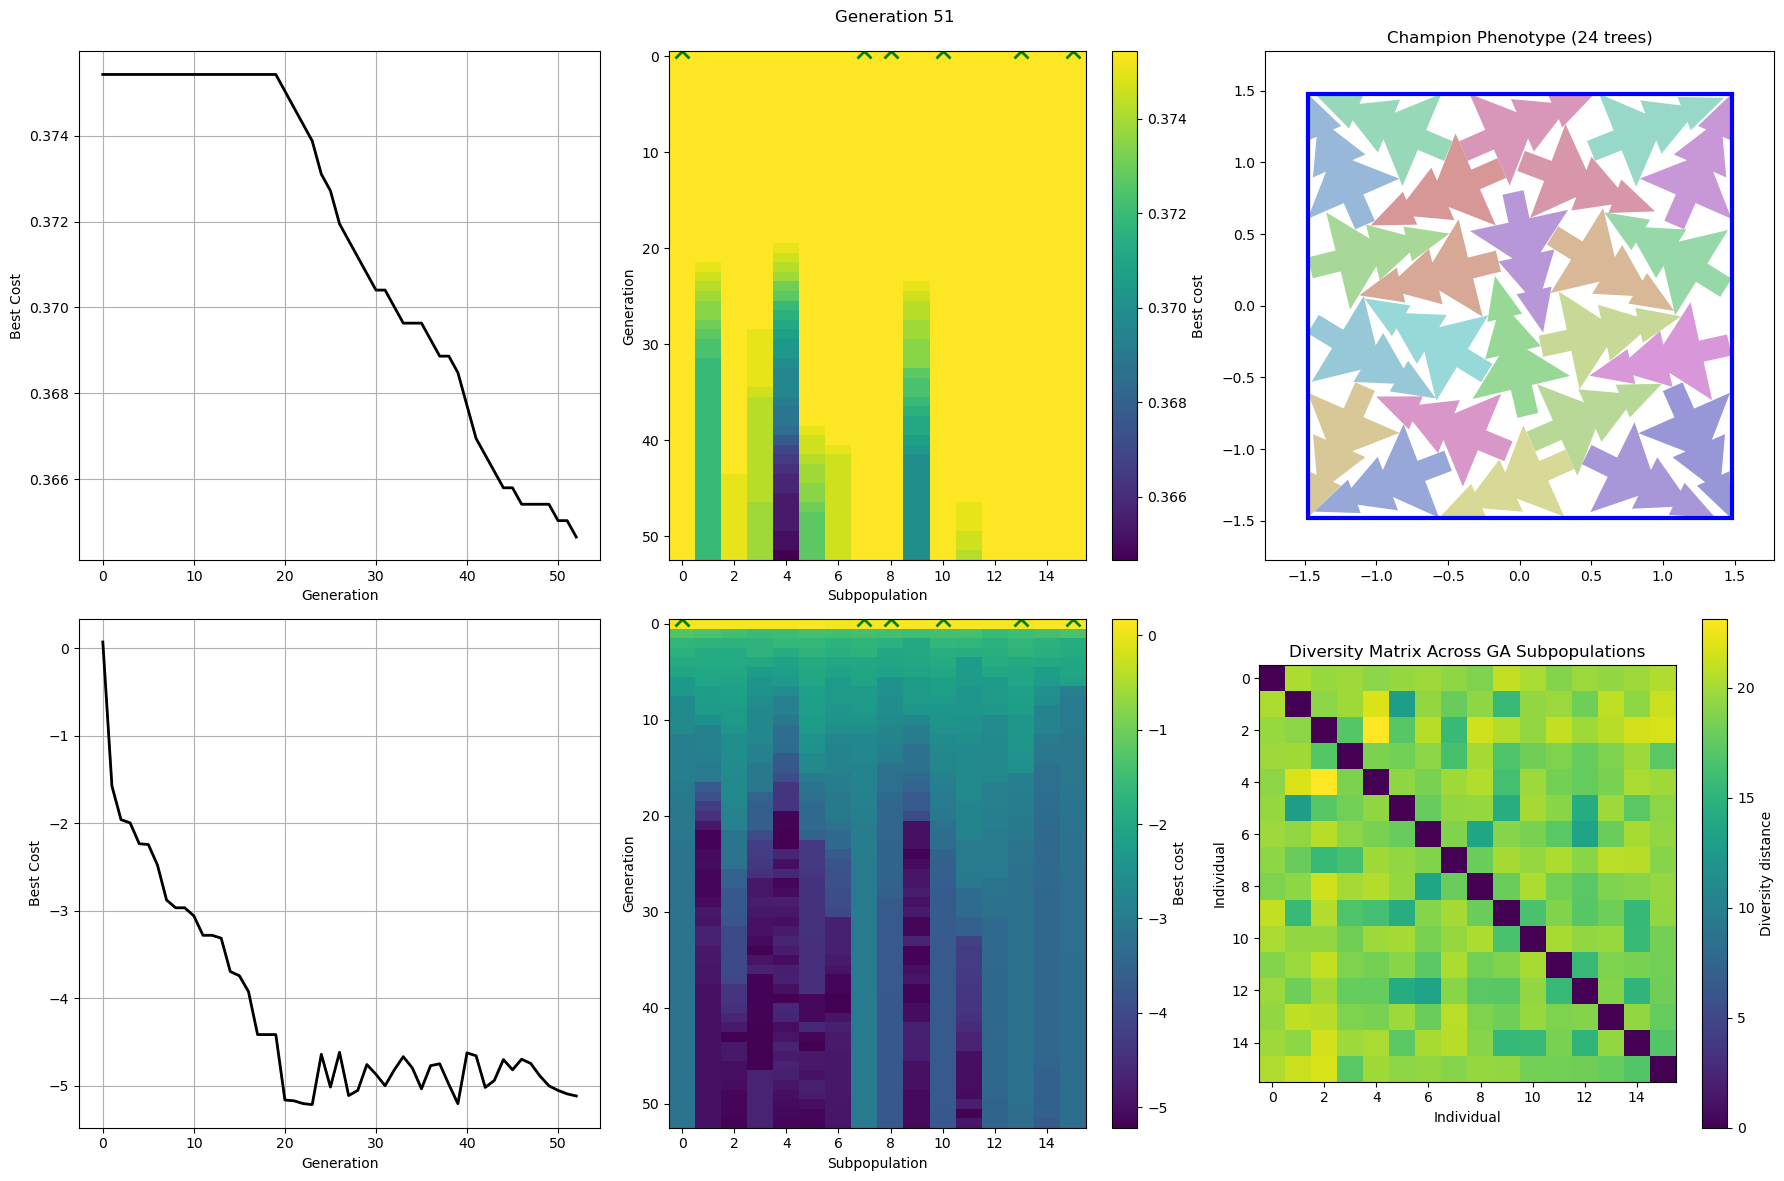

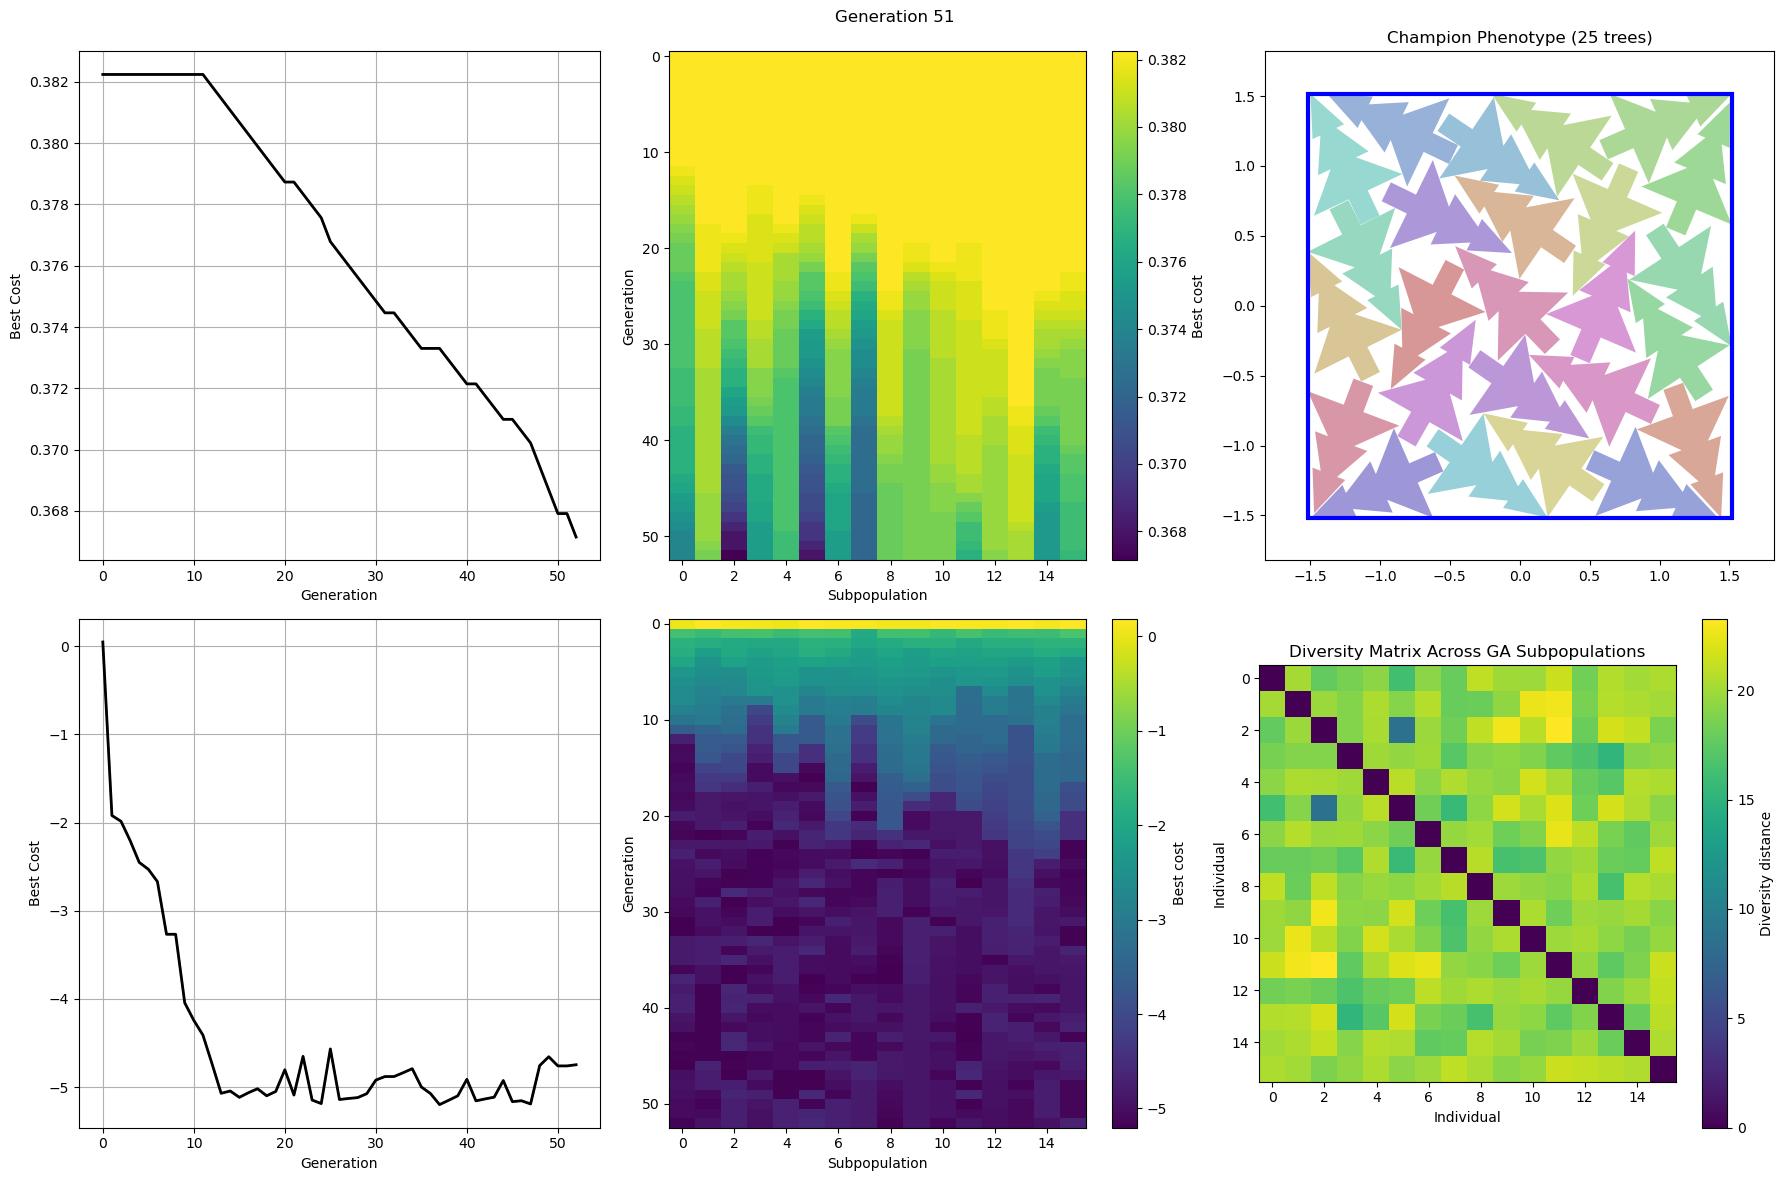

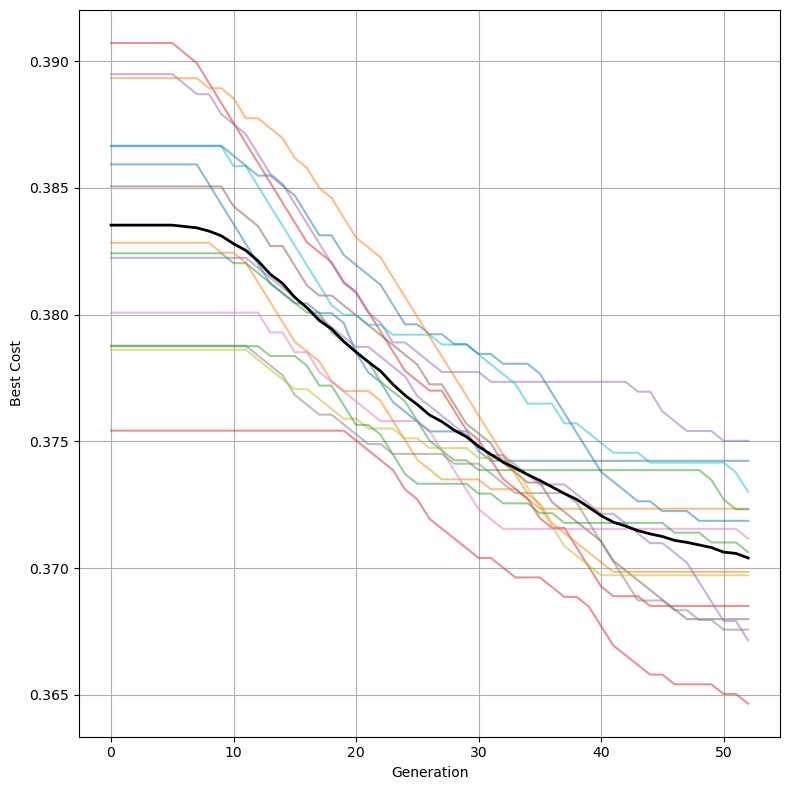

In [ ]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
import pack_ga3 as pack_ga2
import pack_runner
importlib.reload(pack_ga2)
fastMode = False
kgs.debugging_mode = 2 if fastMode else 1

tmp = pack_ga2.GA()

# runner = pack_ga2.Orchestrator(n_generations=3 if not fastMode else 50)
# runner.ga = pack_ga2.GAMultiRing(N=16 if not fastMode else 4)
# runner.ga.diversity_reset_threshold = 5./40
# runner.ga.mate_distance=6

# ga_base = pack_ga2.GASinglePopulationOld(N_trees_to_do=40)
# #ga_base.population_size = 250
# #ga_base.prob_mate_own = 0.25
# value = 0.125
# ga_base.population_size = int(ga_base.population_size * value)
# ga_base.selection_size = [int( (s-1) * value)+1 for s in ga_base.selection_size]
# seen = set()
# unique_selection = []
# for s in ga_base.selection_size:
#     while s in seen:
#         s += 1
#     seen.add(s)
#     unique_selection.append(s)
# ga_base.selection_size = unique_selection
# ga_base.selection_size = ga_base.selection_size[:-6]
# print(ga_base.selection_size)
# ga_base.do_legalize = False
# ga_base.reset_check_generations = 50 if not fastMode else 3
# ga_base.reset_check_threshold = 0.5 if not fastMode else 0.9
# ga_base.freeze_duration = 100 if not fastMode else 3
# #ga_base.move.moves[-1][2] *= 2
# ga_base.prob_mate_own = 0.7
# ga_base.reduce_h_threshold = 1e-5/40
# ga_base.always_allow_mate_with_better = False
# ga_base.fixed_h = -1.

# runner.ga.ga_base = ga_base
# runner.ga.do_legalize = False
# runner.ga.allow_reset_ratio = 0.5 if not fastMode else 0.
# runner.ga.make_own_fig = (2,3)
# runner.ga.make_own_fig_size = (18,12)
# runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)) ,(1,True,(1,0)))
# runner.ga.plot_subpopulation_costs_per_generation_ax = ( (0,False,(0,1)) ,(1,True,(1,1)))
# runner.ga.champion_phenotype_ax = (0,2)
# runner.ga.plot_diversity_ax = (1,2)
# runner.diagnostic_plot = False
# runner.seed = 0

runner_one_nTree = pack_ga2.baseline()
runner_one_nTree.ga.do_legalize = False
runner = copy.deepcopy(runner_one_nTree)

ga_list = []
N_trees_list = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
for N_tree in N_trees_list:
    ga_list.append( copy.deepcopy(runner_one_nTree.ga) )
    ga_list[-1].ga_base.N_trees_to_do = N_tree
    ga_list[-1].do_legalize= False
runner.ga = pack_ga2.GAMulti(single_champion=False)
runner.ga.ga_list = ga_list
runner.ga.make_own_fig = (1,1)
runner.ga.make_own_fig_size = (8,8)
runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)),)
runner.diagnostic_plot = True
runner.plot_every = 3
runner.n_generations = 60000 if not fastMode else 3
runner.filename = f'ga_multi_tree_{np.min(N_trees_list)}_to_{np.max(N_trees_list)}'

runner.seed=84
runner.run()

In [ ]:
runner.ga.ga_list[0].ga_list[0].do_legalize

False

In [ ]:
rr = kgs.dill_load(kgs.temp_dir + runner.filename + '.pickle')

N=11 best score: [0.38593093 0.00535679]
1
1
N=12 best score: [0.38283792 0.00105084]
1
1


<Figure size 640x480 with 0 Axes>

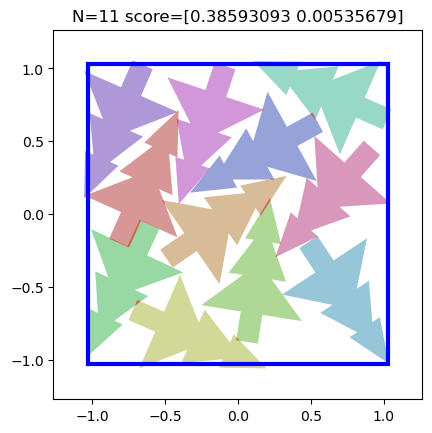

<Figure size 640x480 with 0 Axes>

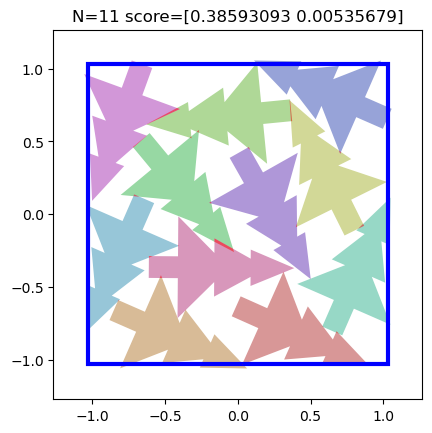

<Figure size 640x480 with 0 Axes>

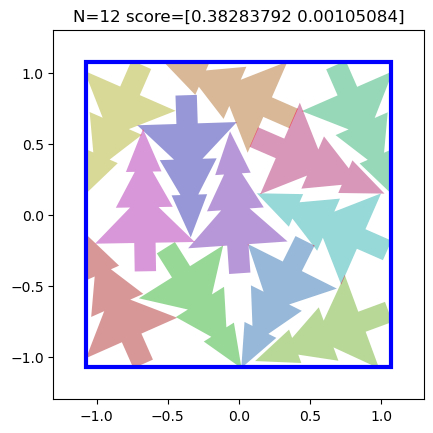

<Figure size 640x480 with 0 Axes>

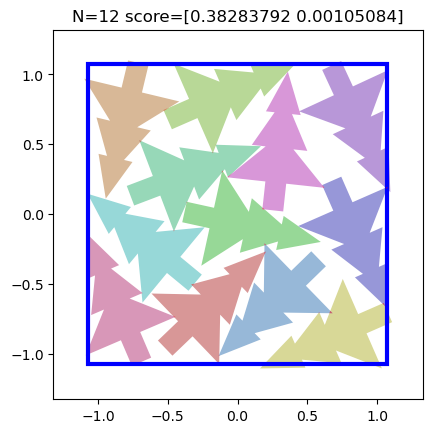

In [ ]:
import pack_vis_sol
#rr.ga.diversity_reset_check_frequency = 1
#for ga in rr.ga.ga_list:
#    ga.diversity_reset_check_frequency = 1
#rr.ga.score(register_best=True) # remove duplicates
for ga in rr.ga.ga_list:
    best_score = ga.champions[-1].fitness[0]
    print(f"N={ga.ga_base.N_trees_to_do} best score: {best_score}")
    ga._fig = None
    ga._ax = None
    #ga.diagnostic_plots(-1,None)
    res = []
    for ga2 in ga.ga_list:        
        if ga2.champions[-1].fitness[0][0] == best_score[0]:
            plt.figure()
            pack_vis_sol.pack_vis_sol(ga2.champions[-1].phenotype)
            plt.title(f"N={ga.ga_base.N_trees_to_do} score={best_score}")
            res.append(ga2.champions[-1].phenotype)
            print(ga2.champions[-1].phenotype.N_solutions)

In [ ]:
# importlib.reload(kgs)
# rrr=copy.deepcopy(res[0])
# rrr.merge(res[1])
# div_matrix = kgs.compute_genetic_diversity_matrix(rrr.xyt, rrr.xyt)
# div_matrix

In [ ]:
for ga in rr.ga.ga_list:
    ga.do_legalize = True
rr.ga.finalize()

Before optimization:  0.04786096140742302 0.005408559925854206 2.060398


In [ ]:
# import pack_io
# sol_list = [ga.champions[-1].phenotype for ga in rr.ga.ga_list]
# df = pack_io.solution_list_to_dataframe(sol_list)

In [ ]:
sol_list = [ga.champions[-1].phenotype for ga in rr.ga.ga_list]
kgs.dill_save(kgs.code_dir + f'../res/' + runner.filename + '.pickle', sol_list)

In [ ]:
print(kgs.code_dir + f'../res/' + runner.filename + '.pickle')

/mnt/d//packing/code/core/../res/runner_multi_tree_{np.min(N_trees_list)}_to_{np.max(N_trees_list)}.pickle
